# Helper functions

In [1]:
import math
from torch import nn

GRID_SIZE_H = 4
GRID_SIZE_V = 5
def location_to_x_y(location):
    return location % (GRID_SIZE_H + 1), math.floor(location / GRID_SIZE_V)

def coord_to_label(coord):
    x = coord[0][0].item()
    y = coord[0][1].item()
    return int(y * GRID_SIZE_V + x)  # Compute label


def label_to_coord(label, grid_size=4):
    x = label % (GRID_SIZE_H + 1)  # Column index
    y = math.floor(label / GRID_SIZE_V)  # Row index
    return torch.tensor([x, y], dtype=torch.float32)

# Train

In [2]:
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm
import os
from IPython.display import Image
from torch.utils.tensorboard import SummaryWriter
from models.networks.cnn import DeepTimeSeriesCNN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, dataset, train_loader, validation_loader, criterion, optimizer, epochs, scheduler, save_name, writer):
    first_data = dataset[1]
    features, labels = first_data
    input_size = features.size()[0] * features.size()[1]

    if os.path.exists(f"outputs/{save_name}"):
        model.load_state_dict(torch.load(f"outputs/{save_name}/model.pt", weights_only=True))
        return model
    else:
        os.makedirs(f"outputs/{save_name}")

    best_epoch = (0, None)
    counter = {}

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        n_correct = 0
        n_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):
            for label in labels:
                if label.item() not in counter.keys():
                    counter[label.item()] = (0, 0)
                counter[label.item()] = (counter[label.item()][0] + 1, counter[label.item()][1])

            # origin shape: [100, 1, 28, 28]
            # resized: [100, 784]
            inputs = inputs.to(device)
            # print("inputs", inputs)
            # noice_matrix = torch.rand(inputs.shape).to(device) * 0.0005
            # inputs = inputs + noice_matrix

            # print("inputs size", inputs.shape)
            labels = labels.to(device)
            # Forward passimport copy
            outputs = model(inputs)
            # print("output size", outputs.shape)

            # print("labels size", labels.shape)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = total_loss / len(train_loader)
        train_acc = n_correct / n_samples

        if train_acc > best_epoch[0]:
            best_epoch = (train_acc, model)

        scheduler.step(total_loss)

        val_loss = 0
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for images, labels in validation_loader:
                for label in labels:
                    if label.item() not in counter.keys():
                        counter[label.item()] = (0, 0)
                    counter[label.item()] = (counter[label.item()][0], counter[label.item()][1] + 1)

                images = images.to(device)

                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                # max returns (value ,index)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

            val_accuracy = n_correct / n_samples

            acc = 100.0 * n_correct / n_samples

            if acc > best_epoch[0]:
                best_epoch = (train_acc, model)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/test', val_accuracy, epoch)

    model = best_epoch[1]
    torch.save(model.state_dict(), f"outputs/{save_name}/model.pt")
    return model

/home/thestone/local_projects/research_project/Research_project_dataprocessing/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


#### regression

In [4]:
def train_regression(model, dataset, train_loader, validation_loader, criterion, optimizer, epochs, scheduler, save_name, writer):

    first_data = dataset[1]
    features, labels = first_data
    input_size = features.size()[0] * features.size()[1]

    if os.path.exists(f"outputs/{save_name}"):
        model.load_state_dict(torch.load(f"outputs/{save_name}/model.pt", weights_only=True))
        return model
    else:
        os.makedirs(f"outputs/{save_name}")

    best_epoch = (0, None)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        n_correct = 0
        n_samples = 0
        for i, (inputs, labels) in enumerate(train_loader):

            # origin shape: [100, 1, 28, 28]
            # resized: [100, 784]
            inputs = inputs.to(device)
            # print("inputs", inputs)
            # noice_matrix = torch.rand(inputs.shape).to(device) * 0.0005
            # inputs = inputs + noice_matrix

            # print("inputs size", inputs.shape)
            target_coords = torch.stack([label_to_coord(lbl) for lbl in labels]).to(device)
            # Forward passimport copy
            outputs = model(inputs)
            # print("output size", outputs.shape)

            # print("labels size", labels.shape)
            loss = criterion(outputs, target_coords)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            correct_compare = target_coords.eq(torch.round(outputs))
            count = torch.sum(torch.all(correct_compare == True, dim=1))

            n_samples += labels.size(0)
            n_correct += count.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = total_loss / len(train_loader)
        train_acc = n_correct / n_samples

        if train_acc > best_epoch[0]:
            best_epoch = (train_acc, model)

        scheduler.step(total_loss)

        # here: 178 samples, batch_size = 4, n_iters=178/4=44.5 -> 45 iterations
        # Run your training process

        val_loss = 0
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                target_coords = torch.stack([label_to_coord(lbl) for lbl in labels]).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, target_coords)
                val_loss += loss.item()
                # max returns (value ,index)
                # print("labels", target_coords.shape)
                # print("outputs", torch.round(outputs).shape)
                # print("compare", target_coords.eq(torch.round(outputs)))
                correct_compare = target_coords.eq(torch.round(outputs))
                count = torch.sum(torch.all(correct_compare == True, dim=1))
                # print(count.item())
                #
                # _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                #
                n_correct += count.item()

            val_accuracy = n_correct / n_samples

            # print(f'Epoch: {epoch + 1}/{self.num_epochs}, Labels {labels.shape}')
            # print(f'Validation acc: {acc:2f} | Train acc:{(train_acc * 100):2f} %')
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/validation', val_loss, epoch)
            writer.add_scalar('Accuracy/train', train_acc, epoch)
            writer.add_scalar('Accuracy/test', val_accuracy, epoch)

    plt.savefig(f"outputs/{name}/train_validation.png")
    #Image(filename=f"outputs/{self.name}/train_validation.png")

    model = best_epoch[1]
    torch.save(model.state_dict(), f"outputs/{name}/model.pt")
    return model

# Test

#### classification

In [5]:
import numpy as np
from sklearn import metrics

def test_classification_network(model, test_loader, writer, save_name, dataset):
    # if test_results is not None:
    #     print("--Test already ran--")
    #     print("avarge distance error: ", test_results["avg_distance_error"])
    #     print("accuracy: ", test_results["accuracy"])
    #     Image(filename=f"outputs/{name}/confusion_matrix.png")
    #     print(f"outputs/{name}/confusion_matrix.png")
    #     return

    model.eval()

    actual_list = []
    predicted_list = []

    average_distance_error = 0
    total_samples = 0
    correct_samples = 0
    location_plot = [([], []) for _ in range(20)]
    accuracy_per_possition = [0] * 20
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            actual_list.append(labels.item())
            predicted_list.append(predicted.item())
            location_plot[labels.item()][0].append(labels.item())
            location_plot[labels.item()][1].append(predicted.item())
            correct_samples += labels.item() == predicted.item()
            average_distance_error += torch.pairwise_distance(label_to_coord(labels.item()) * 0.5, label_to_coord(predicted.item()) * 0.5).item()

            total_samples += 1

    writer.add_text('avarge distance error', str((average_distance_error / total_samples)))
    writer.add_text('accuracy', str((correct_samples / total_samples)))
    print("avarge distance error: ", str((average_distance_error / total_samples)))
    print("accuracy: ", str((correct_samples / total_samples)))

    test_results = {
        "avg_distance_error": (average_distance_error / total_samples),
        "accuracy": (correct_samples / total_samples)
    }
    torch.save(test_results, f"outputs/{save_name}/test_results.pt")

    confusion_matrix = metrics.confusion_matrix(actual_list, predicted_list, normalize='true')
    confusion_matrix = np.round(confusion_matrix, 2)
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size

    # Plot confusion matrix with larger cells

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                                display_labels=[i for i in range(dataset.number_of_classes())])
    cm_display.plot(ax=ax, cmap="Blues", values_format=".2f")  # Ensure values show correctly formatted

    plt.xticks(fontsize=12)  # Adjust tick font size
    plt.yticks(fontsize=12)
    writer.add_figure('confusion_matrix', plt.gcf())
    plt.show()
    #Image(filename=f"outputs/{self.name}/confusion_matrix.png")

    colors = plt.cm.tab20.colors[:20]
    fig, ax = plt.subplots(figsize=(14, 8))
    placed = {}
    correct_per_possition = [0] * 20
    for i, locations in enumerate(location_plot):
        x_cor, y_cor = location_to_x_y(i)
        plt.scatter(x_cor, y_cor, color=colors[i], label=f'Location {i}')
        for location_cor, location_pred in zip(locations[0], locations[1]):
            if i != location_cor:
                assert "error"
            x_pred, y_pred = location_to_x_y(location_cor)
            x_cor, y_cor = location_to_x_y(location_pred)
            if x_cor != x_pred or y_cor != y_pred:
                plt.arrow(x_pred, y_pred, x_cor - x_pred, y_cor - y_pred, color=colors[location_pred],
                          head_width=0.1, head_length=0.1, alpha=0.1)
            else:
                correct_per_possition[i] += 1
        accuracy_per_possition[i] = correct_per_possition[i] / len(locations[0]) if len(locations[0]) != 0 else 0

    location = 0
    for y in range(4):
        for x in range(5):
            plt.text(x, y, str(location), fontsize=11 * (accuracy_per_possition[location] + 0.5),
                     horizontalalignment='center', verticalalignment='center')
            location += 1

    plt.xlabel('x location')
    plt.ylabel('y location')
    plt.title('Position plot on locations')

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    writer.add_figure('testing_locations', plt.gcf())
    plt.show()

#### Regression

In [6]:
def test_regression_network(model, test_loader, writer, save_name, dataset):
    print("--Run test--")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()

    actual_list = []
    predicted_list = []

    average_distance_error = 0
    total_samples = 0
    correct_samples = 0
    location_plot = [([], []) for _ in range(20)]
    accuracy_per_possition = [0] * 20
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            target_coords = torch.stack([label_to_coord(lbl) for lbl in labels]).to(device)
            # max returns (value ,index)
            average_distance_error += torch.pairwise_distance(target_coords * 0.5, outputs * 0.5).item()
            total_samples += 1
            predicted = int(coord_to_label(torch.abs(torch.round(outputs))))
            actual_list.append(labels.item())
            correct_samples += labels.item() == predicted
            predicted_list.append(predicted)
            location_plot[labels.item()][0].append(outputs[0][0].item())
            location_plot[labels.item()][1].append(outputs[0][1].item())

    print("avarge distance error: ", (average_distance_error / total_samples))
    print("accuracy: ", (correct_samples / total_samples))

    test_results = {
        "avg_distance_error": (average_distance_error / total_samples),
        "accuracy": (correct_samples / total_samples)
    }
    torch.save(test_results, f"outputs/{save_name}/test_results.pt")

    confusion_matrix = metrics.confusion_matrix(actual_list, predicted_list, normalize='true')
    confusion_matrix = np.round(confusion_matrix, 2)
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size

    # Plot confusion matrix with larger cells
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                                display_labels=[i for i in range(20)])
    cm_display.plot(ax=ax, cmap="Blues", values_format=".2f")  # Ensure values show correctly formatted

    plt.xticks(fontsize=12)  # Adjust tick font size
    plt.yticks(fontsize=12)
    plt.show()

    plt.xticks(fontsize=12)  # Adjust tick font size
    plt.yticks(fontsize=12)
    plt.savefig(f"outputs/{name}/confusion_matrix.png")
    #Image(filename=f"outputs/{self.name}/confusion_matrix.png")
    print("locationplot", location_plot)
    # colors = plt.cm.tab20.colors[:20]
    # fig, ax = plt.subplots(figsize=(14, 8))
    # placed = {}
    # correct_per_possition = [0] * 20
    # for i, locations in enumerate(location_plot):
    #     x_cor, y_cor = self.location_to_x_y(i)
    #     plt.scatter(x_cor, y_cor, color=colors[i], label=f'Location {i}')
    #     for location_cor, location_pred in zip(locations[0], locations[1]):
    #         if i != location_cor:
    #             assert "error"
    #         x_pred, y_pred = self.location_to_x_y(location_cor)
    #         x_cor, y_cor = self.location_to_x_y(location_pred)
    #         if x_cor != x_pred or y_cor != y_pred:
    #             print(location_pred)
    #             plt.arrow(x_pred, y_pred, x_cor - x_pred, y_cor - y_pred, color=colors[location_pred],
    #                       head_width=0.1, head_length=0.1, alpha=0.1)
    #         else:
    #             correct_per_possition[i] += 1
    #     accuracy_per_possition[i] = correct_per_possition[i] / len(locations[0])

    location = 0
    for y in range(4):
        for x in range(5):
            plt.text(x, y, str(location), fontsize=11 * (accuracy_per_possition[location] + 0.5),
                     horizontalalignment='center', verticalalignment='center')
            location += 1

    plt.xlabel('x location')
    plt.ylabel('y location')
    plt.title('Position plot on locations')

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    writer.add_figure('testing_locations', plt.gcf())
    plt.savefig(f"outputs/{name}/testing_locations.png")
    #Image(filename=f"outputs/{self.name}/testing_locations.png")

    colors = plt.cm.tab20.colors[:20]
    fig, ax = plt.subplots(figsize=(14, 8))
    print("locationplot", location_plot)
    for i, location in enumerate(location_plot):
        plt.scatter(location[0], location[1], color=colors[i], label=f'Location {i}')

    location = 0
    for y in range(4):
        for x in range(5):
            plt.text(x, y, str(location), fontsize=12, horizontalalignment='center', verticalalignment='center')
            location += 1

    plt.xlabel('x location')
    plt.ylabel('y location')
    plt.title('Position plot on locations')

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    writer.add_figure('location_offsets', plt.gcf())
    plt.savefig(f"outputs/{name}/location_offsets.png")


# 5Ghz


## Normal neural network

### Full dataset 80, 10, 10 split

In [6]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.network import NeuralNet

dataset = WifiCSIDataset5Ghz('Mess_5Ghz/data/output_5Ghz.csv', 10, False, False)
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

model = NeuralNet(input_size, 500, dataset.number_of_classes(), device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

name = "5Ghz_lr_0.00001_epoch_250_NeuralNet_size_500"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, dataset)

Dataset already exists, opening dataset...
torch.Size([225978, 10, 64])
(tensor([[-3.7866e+01, -7.6901e+00, -3.9898e+00, -2.2659e+00, -9.7824e-01,
          2.1114e-01,  1.0430e+00,  1.7037e+00,  2.1033e+00,  2.2423e+00,
          2.0828e+00,  1.8349e+00,  1.4111e+00,  7.7419e-01, -4.3572e-02,
         -5.0709e-01, -1.3748e+00, -2.1001e+00, -3.3724e+00, -4.9824e+00,
         -7.2366e+00, -9.9534e+00, -8.1107e+00, -3.5518e+00,  2.9081e-01,
          3.1090e+00,  5.3454e+00, -4.7696e+01, -5.0706e+01, -4.2551e+01,
         -5.4856e+01, -4.4603e+01, -4.4943e+01, -4.4943e+01, -4.2551e+01,
         -4.4603e+01, -4.3153e+01,  0.0000e+00, -1.3197e+00, -3.3019e-01,
          3.5352e-01,  8.1402e-01,  1.0524e+00,  1.1133e+00,  1.0910e+00,
          8.7492e-01,  4.2838e-01, -9.3688e-03, -6.5491e-01, -1.2340e+00,
         -1.6582e+00, -1.9317e+00, -1.9290e+00, -1.4016e+00, -8.1836e-01,
         -1.3791e-01,  3.0616e-01,  6.3994e-01,  8.3606e-01,  7.3093e-01,
          4.8196e-01, -5.4942e-01, -2.4

/home/thestone/local_projects/research_project/Research_project_dataprocessing/.venv/lib/python3.13/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 250/250 [11:04<00:00,  2.66s/it]


avarge distance error:  0.03182353011726677
accuracy:  0.9683143780147807


### Splitting dataset into unseen people

In [ ]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.network import NeuralNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]

print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset5Ghz('Mess_5Ghz/data/output_5Ghz.csv', 10, False, False, remove_names=all_people[0:16], name="people_split_training")
validation_dataset = WifiCSIDataset5Ghz('Mess_5Ghz/data/output_5Ghz.csv', 10, False, False, remove_names=all_people[16:18], name="people_split_validation")
test_dataset = WifiCSIDataset5Ghz('Mess_5Ghz/data/output_5Ghz.csv', 10, False, False, remove_names=all_people[18:20], name="people_split_testing")

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]


train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

model = NeuralNet(input_size, 500, training_dataset.number_of_classes(), device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

name = "5Ghz_lr_0.00001_epoch_250_NeuralNet_size_500_people_split"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, training_dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, dataset)

In [ ]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.larger_network import LargerNetwork

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]

print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset5Ghz('Mess_5Ghz/data/output_5Ghz.csv', 10, False, False, remove_names=all_people[0:16], name="people_split_training")
validation_dataset = WifiCSIDataset5Ghz('Mess_5Ghz/data/output_5Ghz.csv', 10, False, False, remove_names=all_people[16:18], name="people_split_validation")
test_dataset = WifiCSIDataset5Ghz('Mess_5Ghz/data/output_5Ghz.csv', 10, False, False, remove_names=all_people[18:20], name="people_split_testing")

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]


train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

model = LargerNetwork(input_size, training_dataset.number_of_classes(), device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.01)

name = "5Ghz_lr_0.00001_epoch_250_NeuralNet_size_500_people_split_larger_network"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, training_dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, test_dataset)

### removing side positions that perform bad in 60Ghz

In [ ]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.network import NeuralNet

dataset = WifiCSIDataset5Ghz('Mess_5Ghz/data/output_5Ghz.csv', 10, False, False, name="remove_bad_60ghz_pos", remove_locations=[2,5,9,10,14,17])
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

model = NeuralNet(input_size, 500, dataset.number_of_classes(), device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

name = "5Ghz_lr_0.00001_epoch_250_NeuralNet_size_500_people_split_remove_board_pos"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, dataset)

# 60 Ghz

### Normal neural netwerk

In [7]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.network import NeuralNet
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, False, False, subtract_background_noice=True)
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

model = NeuralNet(input_size, 500, dataset.number_of_classes(), device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

name = "60Ghz_lr_0.00001_epoch_500_NeuralNet_size_500"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=500,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, dataset)

cpu
torch.Size([64546, 1, 60])
(tensor([[  8.2033,   7.7206,   8.8393,   7.3203,   5.4075,   7.6832,   4.6333,
           5.5648,   7.2898,   4.8622,   6.9588,   2.8012,   4.3172,   8.7735,
           0.8019,   0.9813,   3.3248,   6.9003,   1.0256,   3.6195,   1.2084,
          -0.4301,   2.4515,  -5.0429,   2.6039,   0.3688,  -1.7462,  -6.1579,
          -1.6634,  -1.4765,  25.8469,   6.2559,  16.9518,   6.3037,  -8.4042,
           0.6290,   5.9477, -12.2658,  23.8528,  12.5077,  24.6109,  16.6440,
           3.5992,  -2.8374,  -7.5979,   1.2289,  17.4605,  30.3563,  23.1872,
          35.1541,  40.5624,  17.9074,  45.9556,  12.2692,  42.3256,  11.8866,
           9.4315,  10.6826,  33.6208,  28.6297]]), 0)
64546


RuntimeError: Invalid device, must be cuda device

In [ ]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.network import NeuralNet
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

for samples in range(1,12,3):
    dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', samples, False, False, subtract_background_noice=True)
    first_data = dataset[1]
    features, labels = first_data
    input_size = features.size()[0] * features.size()[1]

    training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
    train_loader = DataLoader(dataset=training_dataset,
                                      batch_size=50,
                                      shuffle=True)

    validation_loader = DataLoader(dataset=validation_dataset,
                                   batch_size=50,
                                   shuffle=False)

    test_loader = DataLoader(dataset=test_dataset,
                                   shuffle=False)

    model = NeuralNet(input_size, 500, dataset.number_of_classes(), device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

    name = f"60Ghz_lr_0.00001_epoch_450_NeuralNet_size_500_sample{samples}"
    writer = SummaryWriter("outputs/Tensorboard/Sample_Test/" + name)
    model = train(model, dataset, train_loader, validation_loader,
          criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
          optimizer=optimizer,
          epochs=500,
          scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
          save_name=name, writer=writer)
    test_classification_network(model, test_loader, writer, name, dataset)

### Remove bad possitions

In [9]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.network import NeuralNet
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, False, False, subtract_background_noice=True, name="remove_bad_60ghz_pos_1", remove_locations=[2,5,9,10,14,17])
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

model = NeuralNet(input_size, 500, dataset.number_of_classes(), device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

name = "60Ghz_lr_0.00001_epoch_500_NeuralNet_size_500_remove_bad_pos"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=500,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, dataset)

torch.Size([45155, 1, 60])
(tensor([[  8.2033,   7.7206,   8.8393,   7.3203,   5.4075,   7.6832,   4.6333,
           5.5648,   7.2898,   4.8622,   6.9588,   2.8012,   4.3172,   8.7735,
           0.8019,   0.9813,   3.3248,   6.9003,   1.0256,   3.6195,   1.2084,
          -0.4301,   2.4515,  -5.0429,   2.6039,   0.3688,  -1.7462,  -6.1579,
          -1.6634,  -1.4765,  25.8469,   6.2559,  16.9518,   6.3037,  -8.4042,
           0.6290,   5.9477, -12.2658,  23.8528,  12.5077,  24.6109,  16.6440,
           3.5992,  -2.8374,  -7.5979,   1.2289,  17.4605,  30.3563,  23.1872,
          35.1541,  40.5624,  17.9074,  45.9556,  12.2692,  42.3256,  11.8866,
           9.4315,  10.6826,  33.6208,  28.6297]]), 0)
45155


RuntimeError: Invalid device, must be cuda device

### Splitting dataset into unseen people

In [ ]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.network import NeuralNet
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
all_people = ["Andre","Daniel","Heng","Ruben","Peter","Sadegh","Wouter",'Andres maria',"David","Wout","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Maksim","Jacob", "Stein"]

print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, False, False, subtract_background_noice=True, remove_names=all_people[0:16], name="people_split_training_1")
validation_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, False, False, subtract_background_noice=True,remove_names=all_people[16:18], name="people_split_validation_1")
test_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, False, False, subtract_background_noice=True, remove_names=all_people[18:20], name="people_split_testing_1")

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]


train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

model = NeuralNet(input_size, 500, training_dataset.number_of_classes(), device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.4)

name = "60Ghz_lr_0.00001_epoch_250_NeuralNet_size_500_people_split"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, training_dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, test_dataset)

## cnn neural network

In [ ]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 4, False, False, subtract_background_noice=True, name="cnn_4_timesteps")
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

model = DeepTimeSeriesCNN(dataset.number_of_classes(), 0.5, 2, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

name = "60Ghz_lr_0.00001_epoch_250_CNN_items_4_kernal_2"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=500,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, dataset)

### Person split

In [ ]:
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 2, False, False, subtract_background_noice=True)
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 10, False, False, subtract_background_noice=True, remove_names=all_people[0:16], name="people_split_training_steps_10")
validation_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 10, False, False, subtract_background_noice=True,remove_names=all_people[16:18], name="people_split_validation_1_steps_10")
test_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 10, False, False, subtract_background_noice=True, remove_names=all_people[18:20], name="people_split_testing_1_steps_10")

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]


train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

model = DeepTimeSeriesCNN(dataset.number_of_classes(), 0.5, 4, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)

name = "60Ghz_lr_0.00001_epoch_250_CNN_items_12_kernal_2_person_split"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, training_dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=500,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, test_dataset)

### DeepCSINet from paper

In [ ]:
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 8, False, False, subtract_background_noice=True, name="cnn_4_timesteps")
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

model = DeepCSINet(dataset.number_of_classes(), 0.5, 0, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

name = "60Ghz_lr_0.00001_epoch_250_DEEPCSINET_items_8_kernal_2"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, dataset)

### DEEPCSI people split

In [ ]:
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 8, False, False, subtract_background_noice=True, name="cnn_4_timesteps")
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 16, False, False, subtract_background_noice=True, remove_names=all_people[0:16], name="people_split_training_steps_16_people_split")
validation_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 16, False, False, subtract_background_noice=True,remove_names=all_people[16:18], name="people_split_validation_1_steps_16_people_split")
test_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 16, False, False, subtract_background_noice=True, remove_names=all_people[18:20], name="people_split_testing_1_steps_16_people_split")

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]


train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

model = DeepCSINet(input_channels=60, num_classes=training_dataset.number_of_classes(), dropout_rate=0.25, kernel_size=5, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

name = "60Ghz_lr_0.00001_epoch_250_DEEPCSINET_items_16_people_split_remove_locations"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, training_dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=500,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, test_dataset)

In [ ]:
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]

print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 16, False, False, subtract_background_noice=True, name="cnn_4_timesteps")
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)
model = DeepCSINet(input_channels=60, num_classes=dataset.number_of_classes(), dropout_rate=0.25, kernel_size=5, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

name = "60Ghz_lr_0.00001_epoch_250_DEEPCSINET_items_16_people_splo"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, dataset)

#### longer samples

In [ ]:
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]


print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 24, False, False, subtract_background_noice=True, remove_names=all_people[0:16], name="people_split_training_steps_24_people_split")
validation_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 24, False, False, subtract_background_noice=True,remove_names=all_people[16:18], name="people_split_validation_1_steps_24_people_split")
test_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 24, False, False, subtract_background_noice=True, remove_names=all_people[18:20], name="people_split_testing_1_steps_24_people_split")

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]


train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

model = DeepCSINet(input_channels=60, num_classes=training_dataset.number_of_classes(), dropout_rate=0.25, kernel_size=8, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

name = "60Ghz_lr_0.00001_epoch_250_DEEPCSINET_items_24_people_split_remove_locations_kernel_8"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train(model, training_dataset, train_loader, validation_loader,
      criterion=nn.CrossEntropyLoss(size_average=False).cuda(),
      optimizer=optimizer,
      epochs=500,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_classification_network(model, test_loader, writer, name, test_dataset)

## Regression network

In [ ]:
from models.networks.regression_network import Regression_neural_network
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, False, False, subtract_background_noice=True, name="normal_regression")
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

print(dataset.number_of_classes())
model = Regression_neural_network(input_size, 300, 2, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

name = "Regression_450_epoch"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train_regression(model, dataset, train_loader, validation_loader,
      criterion=nn.MSELoss().cuda(),
      optimizer=optimizer,
      epochs=450,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_regression_network(model, test_loader, writer, name, dataset)

In [ ]:
from models.networks.regression_network import Regression_neural_network
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, False, False, subtract_background_noice=True, name="normal_regression_rempove_pos", remove_locations=[2,5,9,10,14,17])
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)

for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

print(dataset.number_of_classes())
model = Regression_neural_network(input_size, 300, 2, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

name = "Regression_450_epoch_remove_pos"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train_regression(model, dataset, train_loader, validation_loader,
      criterion=nn.MSELoss().cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_regression_network(model, test_loader, writer, name, dataset)

In [ ]:
from models.networks.regression_network import Regression_neural_network
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]


print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, True, False, subtract_background_noice=True, remove_names=all_people[0:16], name="regression_people_split", remove_locations=[2,5,9,10,14,17])
validation_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, True, False, subtract_background_noice=True,remove_names=all_people[16:18], name="regression_people_split", remove_locations=[2,5,9,10,14,17])
test_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 1, True, False, subtract_background_noice=True, remove_names=all_people[18:20], name="regression_people_split", remove_locations=[2,5,9,10,14,17])

train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

print(dataset.number_of_classes())
model = Regression_neural_network(input_size, 300, 2, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

name = "Regression_450_epoch_remove_pos_people_remove_1"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train_regression(model, training_dataset, train_loader, validation_loader,
      criterion=nn.MSELoss().cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_regression_network(model, test_loader, writer, name, test_dataset)

In [ ]:
from models.networks.regression_network import Regression_neural_network
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]


print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True, remove_names=all_people[0:16], name="regression_people_split_6", remove_locations=[2,5,9,10,14,17])
validation_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True,remove_names=all_people[16:18], name="regression_people_split_6", remove_locations=[2,5,9,10,14,17])
test_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True, remove_names=all_people[18:20], name="regression_people_split_6", remove_locations=[2,5,9,10,14,17])

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

print(dataset.number_of_classes())
model = Regression_neural_network(input_size, 300, 2, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

name = "Regression_450_epoch_remove_pos_people_remove_6"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train_regression(model, training_dataset, train_loader, validation_loader,
      criterion=nn.MSELoss().cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_regression_network(model, test_loader, writer, name, test_dataset)

In [ ]:
from models.networks.regression_network import Regression_neural_network
from models.networks.DeepCSINet import DeepCSINet
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]


print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True, name="regression_remove_pos_6", remove_locations=[6,14])
validation_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True, name="regression_6")
test_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True, name="regression_6")

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

print(dataset.number_of_classes())
model = Regression_neural_network(input_size, 300, 2, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

name = "Regression_450_epoch_remove_pos_6"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train_regression(model, training_dataset, train_loader, validation_loader,
      criterion=nn.MSELoss().cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_regression_network(model, test_loader, writer, name, test_dataset)

10543
tensor([[[ -1.7967,  59.7206,  36.8393,  ...,  12.6826,  19.6208,  14.6297],
         [-12.7967,  55.7206,  75.8393,  ...,  14.6826,  20.6208,  18.6297],
         [-20.7967,  57.7206,  67.8393,  ...,  16.6826,  25.6208,  20.6297],
         [-28.7967,  45.7206,  47.8393,  ...,  14.6826,  20.6208,  18.6297],
         [-38.7967,  46.7206,  44.8393,  ...,  11.6826,  18.6208,  16.6297],
         [-57.7967,   7.7206,   8.8393,  ...,  18.6826,  26.6208,  22.6297]],

        [[ -1.7967,   0.7206,   0.8393,  ...,  11.6826,  21.6208,  11.6297],
         [ -2.7967,  -1.2794,  -1.1607,  ...,   6.6826,  17.6208,   4.6297],
         [ -0.7967,  -2.2794,  -1.1607,  ...,   7.6826,  20.6208,   6.6297],
         [ -2.7967,  -1.2794,  -1.1607,  ...,   4.6826,  15.6208,   4.6297],
         [ -5.7967,  -5.2794,  -7.1607,  ...,   8.6826,  17.6208,   6.6297],
         [ -0.7967,  -0.2794,  -1.1607,  ...,   4.6826,  11.6208,   3.6297]],

        [[ 37.2033,  53.7206,  86.8393,  ...,  41.6826,  15.6208, 

100%|██████████| 250/250 [03:07<00:00,  1.33it/s]


--Run test--
avarge distance error:  0.2624412043389975
accuracy:  0.6840607210626186


<Figure size 640x480 with 0 Axes>

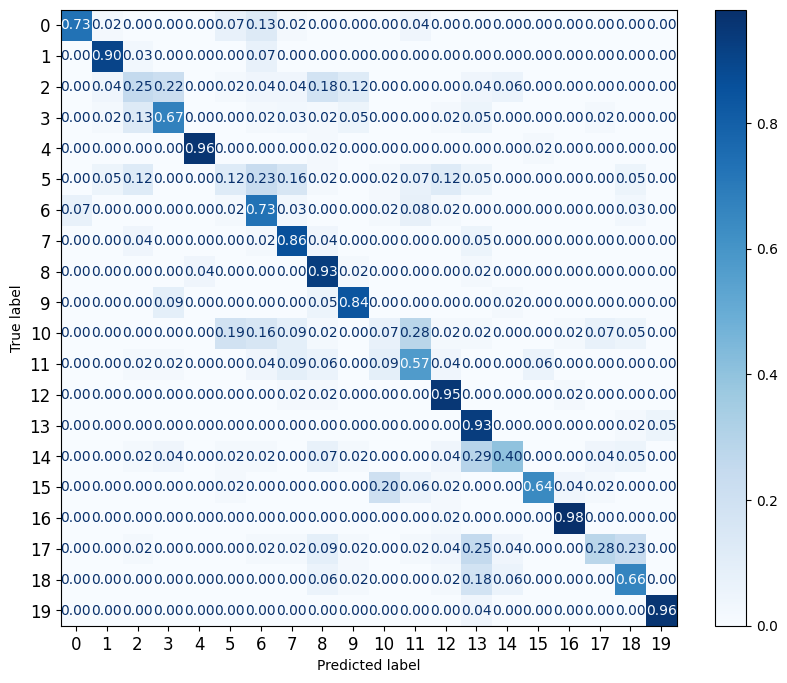

locationplot [([0.040689900517463684, 0.11953850835561752, 0.06983809173107147, 0.06115178391337395, 0.047141462564468384, 0.009956243447959423, 0.471622496843338, 0.04537278786301613, 0.09096259623765945, 0.528557538986206, 0.22578458487987518, 0.006276946514844894, 0.8517813682556152, 0.014136685989797115, 0.04515485092997551, 0.09901629388332367, 0.10659167915582657, 0.0340493805706501, 0.030623337253928185, 0.19872447848320007, 0.05255994573235512, 0.045610230416059494, 0.6112277507781982, 0.04069322347640991, 0.02868114411830902, 0.18946409225463867, 0.8798931837081909, 1.0079078674316406, 1.568224310874939, 0.656684935092926, 0.557727575302124, 0.18950635194778442, 0.09323761612176895, 0.10270604491233826, 0.17859919369220734, 0.12826448678970337, 0.005569981411099434, 0.05324564501643181, 0.1063961312174797, 0.06729032099246979, 0.1121763288974762, 0.05947235971689224, 0.06771067529916763, 0.004860201850533485, 0.07294303923845291, 0.6682621836662292, 0.18863023817539215, 0.2777

/tmp/ipykernel_531306/3472047616.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


<Figure size 640x480 with 0 Axes>

In [23]:
from models.networks.DeepCSINetRegression import DeepCSINetRegression
from models.networks.regression_network import Regression_neural_network
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, False, False, subtract_background_noice=True, name="normal_regression_6")
first_data = dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

training_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))
train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

print(dataset.number_of_classes())
model = DeepCSINetRegression(input_channels=60, num_classes=2, dropout_rate=0.25, kernel_size=5, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

name = "DEEPCSI_Regression_250_epoch_6_1"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train_regression(model, dataset, train_loader, validation_loader,
      criterion=nn.MSELoss().cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_regression_network(model, test_loader, writer, name, dataset)

Training ['Andre', 'Daniel', 'Heng', 'Maksim', 'Peter', 'Sadegh', 'Wouter', 'Andres maria', 'David', 'Jacob', 'Matthias', 'Priyesh', 'Xinlei liu', 'Arno', 'Fabian', 'Lynn']
Validation ['Nabeel', 'Ruben']
Testing ['Wout', 'Stein']
9486
10543
10543
tensor([[[ -0.7967,  -2.2794,   0.8393,  ...,  -0.3174,  -5.3792,  -6.3703],
         [  2.2033,   0.7206,   2.8393,  ...,  -5.3174, -11.3792, -10.3703],
         [  2.2033,  -1.2794,   3.8393,  ...,   1.6826,  -3.3792,  -2.3703],
         [ -3.7967,  -0.2794,  -1.1607,  ...,   1.6826,  -2.3792,  -5.3703],
         [ -1.7967,  -2.2794,   2.8393,  ...,  -4.3174,  -9.3792,  -7.3703],
         [ -0.7967,  -3.2794,  -1.1607,  ...,  -7.3174,  -9.3792, -11.3703]],

        [[  5.2033,   4.7206,   5.8393,  ...,  17.6826,  12.6208,  14.6297],
         [  0.2033,   0.7206,  -1.1607,  ...,  23.6826,  14.6208,  16.6297],
         [ -1.7967,  -0.2794,  -0.1607,  ...,  14.6826,  10.6208,  14.6297],
         [ -0.7967,  -1.2794,  -2.1607,  ...,  17.6826,  1

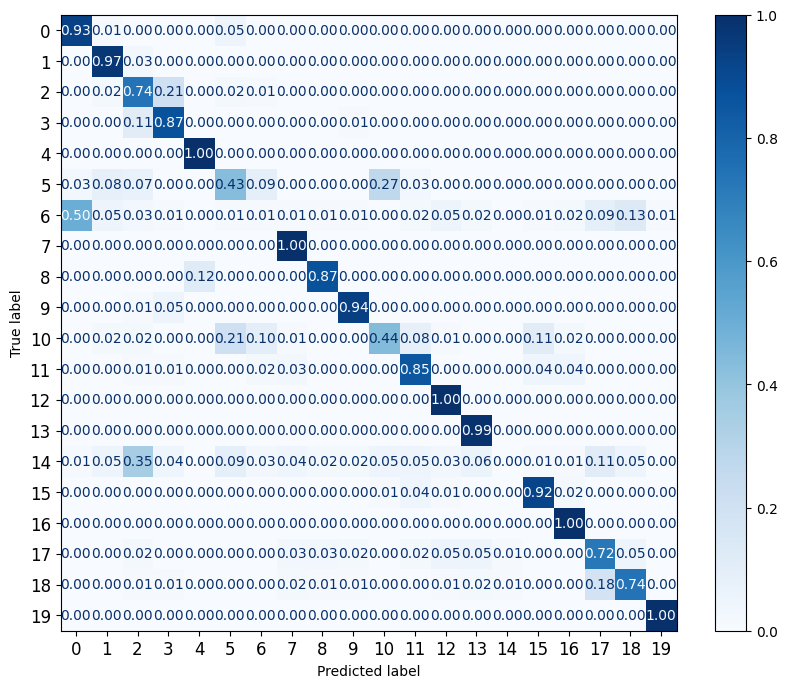

locationplot [([5.304708247422241e-05, 0.0001034523593261838, 0.00032177017419598997, 0.00031318003311753273, 0.00039895015652291477, 4.1800973122008145e-05, 0.0007060273201204836, 1.607864987818175e-06, 0.00010608854790916666, 4.541471298580291e-06, 4.182405609753914e-05, 1.1577664160711265e-08, 8.381090992770623e-06, 2.8768852189386962e-08, 3.316781089779397e-07, 9.658536015422214e-08, 4.909012574216831e-08, 3.0206458632164868e-06, 5.095976666780189e-05, 5.390907517721644e-06, 3.995874919837661e-07, 1.9816475571587944e-07, 9.962508329408593e-08, 8.444451964351174e-07, 2.8472863178308216e-08, 1.1204460292901786e-07, 1.1372802646292257e-06, 3.0089879032857425e-07, 7.806185635672591e-07, 5.585121698459261e-07, 2.237612761746277e-06, 1.0103291003815684e-07, 1.0821483442668978e-07, 2.4356297217309475e-05, 0.00011009424633812159, 1.0367150025558658e-05, 1.1303394785500132e-05, 1.063425497704884e-05, 4.122405698581133e-06, 6.470882908615749e-06, 3.3601399991312064e-06, 2.916463245128398e-06

/tmp/ipykernel_531306/3472047616.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


<Figure size 640x480 with 0 Axes>

In [20]:
from models.networks.DeepCSINetRegression import DeepCSINetRegression
from models.networks.regression_network import Regression_neural_network
from torch.utils.data import DataLoader
from models.Mess_5Ghz.dataset import WifiCSIDataset as WifiCSIDataset5Ghz
from models.networks.cnn import DeepTimeSeriesCNN
from models.Mess_60Ghz.dataset import WifiCSIDataset as WifiCSIDataset60Ghz

all_people = ["Andre","Daniel","Heng","Maksim","Peter","Sadegh","Wouter",'Andres maria',"David","Jacob","Matthias","Priyesh",'Xinlei liu',"Arno","Fabian","Lynn","Nabeel","Ruben","Wout", "Stein"]


print("Training", all_people[0:16])
print("Validation", all_people[16:18])
print("Testing", all_people[18:20])

training_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True, name="DEEPCSI_regression_remove_pos_6_training", remove_locations=[6,14])
validation_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True, name="DEEPCSI_regression_6_validation")
test_dataset = WifiCSIDataset60Ghz('Mess_60Ghz/data/60Ghz_position_data.csv', 6, True, False, subtract_background_noice=True, name="DEEPCSI_regression_6_testing")

first_data = training_dataset[1]
features, labels = first_data
input_size = features.size()[0] * features.size()[1]

train_loader = DataLoader(dataset=training_dataset,
                                  batch_size=50,
                                  shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=50,
                               shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                               shuffle=False)


for i, (inputs, labels) in enumerate(train_loader):
    print(inputs, labels)

print(training_dataset.number_of_classes())
model = DeepCSINetRegression(input_channels=60, num_classes=2, dropout_rate=0.25, kernel_size=5, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

name = "DEEPCSI_Regression_250_epoch_remove_pos_6"
writer = SummaryWriter("outputs/Tensorboard/" + name)
model = train_regression(model, training_dataset, train_loader, validation_loader,
      criterion=nn.MSELoss().cuda(),
      optimizer=optimizer,
      epochs=250,
      scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10),
      save_name=name, writer=writer)
test_regression_network(model, test_loader, writer, name, test_dataset)